In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import pairwise_distances
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import ChebConv
from collections import Counter
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
'''读取数据'''
data_path = '../concatData.xlsx'
MCI_AD_Data = pd.read_excel(data_path,sheet_name="MCI_AD")

## 0、数据均衡

In [3]:
from sklearn.neighbors import NearestNeighbors

'''过采样方法'''
def find_and_remove_danger_samples(X, y, k=5): 
    X = np.array(X)
    y = np.array(y)
    majority_class = max(set(y), key=list(y).count)
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    danger_indices = []
    for idx, x in enumerate(X):
        if y[idx] == majority_class:
            neighbors = neigh.kneighbors([x], return_distance=False)
            neighbor_labels = y[neighbors[0]]
            minority_count = np.sum(neighbor_labels != majority_class)
            if minority_count > k / 2:
                danger_indices.append(idx)
    X_cleaned = np.delete(X, danger_indices, axis=0)
    y_cleaned = np.delete(y, danger_indices, axis=0)
    
    return X_cleaned, y_cleaned

In [4]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import BorderlineSMOTE

cg_X = MCI_AD_Data[['PTGENDER', 'PTMARRY', 'AGE','PTEDUCAT', 
                  'cov_prs',
                  'cg14718065','cg09440270', 'cg06980531', 'cg04143909', 'cg08026735', 'cg16664778',
                  'cg05313129', 'cg02168442', 'cg22832802', 'cg15802263',
                   'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE',
                   'RAVLTimmediate', 'RAVLTlearning', 'RAVLTforgetting',
                   'RAVLTpercforgetting', 'LDELTOTAL', 'TRABSCOR', 'FAQ']]
cg_y = MCI_AD_Data['status']
print('原始 dataset shape %s' % Counter(cg_y))


'''过采样'''
sm = BorderlineSMOTE(
    random_state=42,
    kind="borderline-1",
    sampling_strategy={0: 345, 1: 200 },
    k_neighbors=5, #确定邻居点的数量
    m_neighbors=10) #指定在合成样本生成过程中从近邻点中选择多少个样本作为参考
X_bdsmote, y_bdsmote = sm.fit_resample(cg_X, cg_y)
print('过采样 dataset shape %s' % Counter(y_bdsmote))
# 合并为一个新的dataframe
y_bdsmote = pd.Series(y_bdsmote,name="status")
data_bdsmote = pd.concat([X_bdsmote, y_bdsmote], axis=1)


'''欠采样'''
X_cleaned, y_cleaned = find_and_remove_danger_samples(X_bdsmote.values, data_bdsmote["status"], k=100)
print(f"欠采样 dataset shape: {Counter(y_cleaned)}")
# 合并为一个新的dataframe
X_bdknn = pd.DataFrame(X_cleaned,columns=X_bdsmote.columns)
y_bdknn = pd.Series(y_cleaned,name="status")
data_bdknn = pd.concat([X_bdknn, y_bdknn], axis=1)

原始 dataset shape Counter({0: 345, 1: 35})
过采样 dataset shape Counter({0: 345, 1: 200})
欠采样 dataset shape: Counter({0: 306, 1: 200})


In [5]:
from sklearn.preprocessing import StandardScaler

# # 标准化
standard_scaler = StandardScaler()
standard_scaler.fit(X_bdknn)
X_bdknn = standard_scaler.transform(X_bdknn)
X_sample = pd.DataFrame(X_bdknn,columns=['PTGENDER', 'PTMARRY', 'AGE','PTEDUCAT', 
                                          'cov_prs',
                                          'cg14718065','cg09440270', 'cg06980531', 'cg04143909', 'cg08026735', 'cg16664778',
                                          'cg05313129', 'cg02168442', 'cg22832802', 'cg15802263',
                                           'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE',
                                           'RAVLTimmediate', 'RAVLTlearning', 'RAVLTforgetting',
                                           'RAVLTpercforgetting', 'LDELTOTAL', 'TRABSCOR', 'FAQ'])
y_sample = y_bdknn

In [6]:
X_data = X_sample[['PTGENDER', 'PTMARRY', 'AGE','PTEDUCAT','cov_prs',
                  'cg14718065','cg09440270', 'cg06980531', 'cg04143909', 'cg08026735', 'cg16664778',
                  'cg05313129', 'cg02168442', 'cg22832802', 'cg15802263']]
X_cognitions = X_sample[['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE',
                       'RAVLTimmediate', 'RAVLTlearning', 'RAVLTforgetting',
                       'RAVLTpercforgetting', 'LDELTOTAL', 'TRABSCOR', 'FAQ']]
y_data = y_sample

## 1、构建邻接矩阵

### （0）根据三类特征构建邻接矩阵

In [7]:
'''根据三类特征数据计算相邻矩阵'''

# 计算皮尔逊相关系数矩阵
corr = np.corrcoef(X_data, rowvar=True)
corr = corr.tolist()

# 构建 clinic_prs_methy_edge
matrix_clinic_prs_methy = np.zeros_like(corr)  # 初始化为零矩阵，形状与 corr 相同

for i in range(len(corr)):
    for j in range(len(corr[i])):
        if i != j:  # 排除对角线元素
            current_value = corr[i][j]
            if current_value > 0.5 or current_value <= -0.5:  # 只保留相似度大于 0.5 的样本对
                matrix_clinic_prs_methy[i][j] = 1  # 将满足条件的元素设为 1

### （1）根据KNN构建邻接矩阵

In [8]:
# 使用 k-Nearest Neighbors 算法计算近邻
knn_model = KNeighborsClassifier(n_neighbors=2 ,p=5, weights='uniform')
knn_model.fit(X_data, y_data)  
knn_matrix = knn_model.kneighbors_graph(X_data).toarray()

### （2）权重矩阵

In [9]:
# 合并两种带边的节点矩阵
node_matrix  = matrix_clinic_prs_methy + knn_matrix
node_matrix[node_matrix == 2] = 1  ## 将结果中为 2 的元素替换为 1

# 创建一个与 node_matrix 大小相同，且所有元素都为 1 的矩阵
ones_matrix = np.ones_like(node_matrix)

# 输入矩阵(将联合矩阵的权重赋为这个)
cog_weighted_matrix = node_matrix * ones_matrix

# 自连接逻辑
# np.fill_diagonal(node_matrix, 1)

### （3）数据处理

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [11]:
X_features = np.array(X_data)
X_features = torch.from_numpy(X_features)
X_nodes = X_features.to(torch.float)

y_status = y_data.astype(int)
y_status = torch.from_numpy(y_status.values)
y_status = y_status.to(torch.long)


In [12]:
# 将 NumPy 数组转换为 PyTorch 张量
node_matrix = torch.from_numpy(node_matrix)

# 提取等于1的边
edge_index = torch.nonzero(node_matrix == 1, as_tuple=False).t().contiguous()

# 假设所有边的权重都是1
edge_weight = torch.ones((edge_index.size(1),), dtype=torch.float)

# 假设 X_data 和 y_data 已经定义并转换为合适的 PyTorch 张量
# X_nodes = torch.from_numpy(X_data).to(torch.float)
# y_status = torch.from_numpy(y_data.astype(int)).to(torch.long)

# 创建 PyTorch Geometric 的数据对象
data = Data(x=X_nodes, y=y_status, edge_index=edge_index, edge_attr=edge_weight)

print(data)

Data(x=[506, 15], edge_index=[2, 24498], edge_attr=[24498], y=[506])


## 2、GCN+SAGE 神经网络

In [13]:
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

class AD_GCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(15, 8)  # 假设输入特征为15
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = SAGEConv(8, 3)
        self.bn2 = nn.BatchNorm1d(3)
        self.fc = nn.Linear(3, 1)  # 二分类输出层
    
    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        return self.fc(x)  # 使用 BCEWithLogitsLoss，去掉 sigmoid

# 准备节点的索引进行交叉验证
node_indices = list(range(data.num_nodes))
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kfold.split(node_indices)):
    model = AD_GCN()  # 为每个折叠重新创建模型
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.BCEWithLogitsLoss()  # 使用 BCEWithLogitsLoss
    
    best_loss = float('inf')  # 初始化为正无穷大
    best_out = None  # 初始化为None
    best_metrics = {}

    for epoch in range(1, 201):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)  # 使用整个图
        loss = criterion(out[train_idx], data.y[train_idx].unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            pred = pred = (torch.sigmoid(out[test_idx]) > 0.5).long()  # 使用 threshold 转换为类别标签
            accuracy = accuracy_score(data.y[test_idx].cpu().numpy(), pred.cpu().numpy())
            precision = precision_score(data.y[test_idx].cpu(), pred.cpu(),average='weighted')
            mcc = matthews_corrcoef(data.y[test_idx].cpu(), pred.cpu())
 
        if loss.item() < best_loss:  # 更新最佳损失和指标
                best_loss = loss.item()
                best_metrics = {'MCC': mcc, 'Accuracy': accuracy, 'Precision': precision}
 
        # 打印最佳迭代结果
        if epoch % 200 == 0:  # 每20个epoch打印一次
#             print(f'Fold:{fold}, Epoch: {epoch:03d}, Loss: {best_loss:.3f}, Best Metrics: {best_metrics}')
            print(f'{best_metrics}')

{'MCC': 0.6060598571656328, 'Accuracy': 0.803921568627451, 'Precision': 0.8064146890263502}
{'MCC': 0.33679239361247176, 'Accuracy': 0.6831683168316832, 'Precision': 0.6969529882770361}
{'MCC': 0.5419871253027571, 'Accuracy': 0.7821782178217822, 'Precision': 0.7812009772405812}
{'MCC': 0.5685851736753468, 'Accuracy': 0.7821782178217822, 'Precision': 0.8152858764137283}
{'MCC': 0.6511926915987009, 'Accuracy': 0.8316831683168316, 'Precision': 0.8311426676166377}


In [39]:
# 初始化字典，每个指标都对应一个空列表
results = {
    "MCC": [],
    "Accuracy": [],
    "Precision": []
}

# 原始数据
MCI_AD_folds_data_neighbor = [
    {'MCC': 0.6060598571656328, 'Accuracy': 0.803921568627451, 'Precision': 0.8064146890263502},
    {'MCC': 0.33679239361247176, 'Accuracy': 0.6831683168316832, 'Precision': 0.6969529882770361},
    {'MCC': 0.5419871253027571, 'Accuracy': 0.7821782178217822, 'Precision': 0.7812009772405812},
    {'MCC': 0.5685851736753468, 'Accuracy': 0.7821782178217822, 'Precision': 0.8152858764137283},
    {'MCC': 0.6511926915987009, 'Accuracy': 0.8316831683168316, 'Precision': 0.8311426676166377}
]

# 遍历每一折的数据
for fold_data in MCI_AD_folds_data_neighbor:
    results['MCC'].append(fold_data['MCC'])
    results['Accuracy'].append(fold_data['Accuracy'])
    results['Precision'].append(fold_data['Precision'])

# 输出结果，确保数据已正确添加
print(results)


{'MCC': [0.6823729747055391, 0.7163279717599775, 0.704550312668966, 0.7343344667793078, 0.6375355777548621], 'Accuracy': [0.8507462686567164, 0.8636363636363636, 0.8484848484848485, 0.8636363636363636, 0.8181818181818182], 'Precision': [0.8518920548771295, 0.8702408702408704, 0.866750453847228, 0.8716222049555383, 0.8193548387096774]}


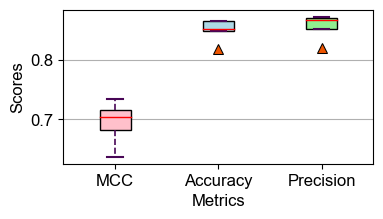

In [40]:
import matplotlib.pyplot as plt
import numpy as np
 
#! 解决不显示的问题：中文设置为宋体格式
plt.rcParams['font.family'] = ["Arial"]
plt.rcParams['font.size'] = 12


# 创建 DataFrame
df_metrics = pd.DataFrame(results)
labels = df_metrics.columns
all_data = [df_metrics[col].values for col in df_metrics]

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(4, 2))

# 绘制带缺口的箱形图
bplot_notch = ax.boxplot(
    all_data,             # 使用准备好的数据列表
    notch=False,           # 带有缺口
    widths=0.3,           # 箱宽度
    labels=labels,        # 设置标签为列名
    patch_artist=True,    # 填充颜色
    medianprops={'linestyle': '-', 'color': 'red', 'linewidth': 1},
    showfliers=True,      # 显示离群点
    flierprops={'marker': '^', 'markersize': 6.75, 'markeredgewidth': 0.75, 'markerfacecolor': '#ee5500', 'markeredgecolor': 'black'},
    whiskerprops={'linestyle': '--', 'linewidth': 1.2, 'color': '#480656'},
    capprops={'linestyle': '-', 'linewidth': 1.5, 'color': '#480656'}
)

# 设置标题
ax.set_title("")

# 为箱形图填充颜色
colors = ['pink', 'lightblue', 'lightgreen']
for patch, color in zip(bplot_notch['boxes'], colors):
    patch.set_facecolor(color)

# 添加水平网格线并设置轴标签
ax.yaxis.grid(True)
ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")

plt.show()

In [ ]:
Epoch: 199, Loss: 0.1115, MCC: 0.9404, Acc: 0.8857, Precision: 0.9400, Recall: 0.9475, F1: 0.9400, CM: [[52  6], [ 0 42]]